In [2]:
import pandas as pd
import os
import wrangle
import matplotlib as plt
import seaborn as sns
import numpy as np
from env import host, user, password
from wrangle import wrangle_zillow
import pandas as pd
import env
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def get_connection(db, username=user, host=host, password=password):
    return f'mysql+pymysql://{username}:{password}@{host}/{db}'

## Aquiring the data

In [ ]:
sql = """
        SELECT prop.*,
        predictions_2017.logerror,
        predictions_2017.transactiondate,
        air.airconditioningdesc,
        arch.architecturalstyledesc,
        build.buildingclassdesc,
        heat.heatingorsystemdesc,
        land.propertylandusedesc,
        story.storydesc,
        type.typeconstructiondesc
        FROM properties_2017 prop
        JOIN (
            SELECT parcelid, MAX(transactiondate) AS max_transactiondate
            FROM predictions_2017
            GROUP BY parcelid
            ) pred USING(parcelid)
        JOIN predictions_2017 ON pred.parcelid = predictions_2017.parcelid
                          AND pred.max_transactiondate = predictions_2017.transactiondate
        LEFT JOIN airconditioningtype air USING(airconditioningtypeid)
        LEFT JOIN architecturalstyletype arch USING(architecturalstyletypeid)
        LEFT JOIN buildingclasstype build USING(buildingclasstypeid)
        LEFT JOIN heatingorsystemtype heat USING(heatingorsystemtypeid)
        LEFT JOIN propertylandusetype land USING(propertylandusetypeid)
        LEFT JOIN storytype story USING(storytypeid)
        LEFT JOIN typeconstructiontype type USING(typeconstructiontypeid)
        WHERE propertylandusedesc = "Single Family Residential"
            AND transactiondate <= '2017-12-31'
            AND prop.longitude IS NOT NULL
            AND prop.latitude IS NOT NULL
    """

df = pd.read_sql(sql, get_connection("zillow"));

In [ ]:
df.info()

In [ ]:
df.head()

In [ ]:
pd.set_option('display.max_columns', None)

df.head()

In [ ]:
df.shape

## Nulls of rows

In [ ]:

nulls_col = pd.DataFrame({'num_rows_missing': df.isnull().sum(), 
              'percent_rows_missing': (df.isnull().sum() / df.shape[0] * 100)})
pd.set_option('display.max_columns', None)
nulls_col.sort_values(by='num_rows_missing', ascending=False).head(10)

In [ ]:
def nulls_by_col(df):
    num_missing = df.isnull().sum()
    rows = df.shape[0]
    prcnt_miss = num_missing / rows * 100
    cols_missing = pd.DataFrame({'num_rows_missing': num_missing, 'percent_rows_missing': prcnt_miss})
    return cols_missing.sort_values(by='num_rows_missing', ascending=True)


In [ ]:
Number of 

In [ ]:
nulls_by_col(df)

## Nulls of collums 

In [ ]:
nulls_row = pd.DataFrame({'num_cols_missing': df.isnull().sum(axis=1),
              'percent_cols_missing': df.isnull().sum(axis=1)/df.shape[1]*100})

nulls_row

- honestly there is so much missing in my cluster excercizez imma keep it simple and just do what i did and keep 60% of the data 

In [ ]:
def nulls_by_row(df):
    num_missing = df.isnull().sum(axis=1)
    prcnt_miss = num_missing / df.shape[1] * 100
    rows_missing = pd.DataFrame({'num_cols_missing': num_missing, 'percent_cols_missing': prcnt_miss})
    rows_missing = df.merge(rows_missing,
                        left_index=True,
                        right_index=True)[['parcelid', 'num_cols_missing', 'percent_cols_missing']]
    return rows_missing.sort_values(by='num_cols_missing', ascending=False)

In [ ]:
def summarize(df):
    '''
    summarize will take in a single argument (a pandas dataframe) 
    and output to console various statistics on said dataframe, including:
    # .head()
    # .info()
    # .describe()
    # .value_counts()
    # observation of nulls in the dataframe
    '''
    print('SUMMARY REPORT')
    print('=====================================================\n\n')
    print('Dataframe head: ')
    print(df.head(3))
    print('=====================================================\n\n')
    print('Dataframe info: ')
    print(df.info())
    print('=====================================================\n\n')
    print('Dataframe Description: ')
    print(df.describe())
    num_cols = [col for col in df.columns if df[col].dtype != 'O']
    cat_cols = [col for col in df.columns if col not in num_cols]
    print('=====================================================')
    print('DataFrame value counts: ')
    for col in df.columns:
        if col in cat_cols:
            print(df[col].value_counts(), '\n')
        else:
            print(df[col].value_counts(bins=10, sort=False), '\n')
    print('=====================================================')
    print('nulls in dataframe by column: ')
    print(nulls_by_col(df))
    print('=====================================================')
    print('nulls in dataframe by row: ')
    print(nulls_by_row(df))
    print('=====================================================')


In [ ]:
summarize(df)


## now im going to drop collumns and rows

In [ ]:
def remove_columns(df, cols_to_remove):
    df = df.drop(columns=cols_to_remove)
    return df

In [ ]:
def handle_missing_values(df, prop_required_columns=0.75, prop_required_row=0.75):
    threshold = int(round(prop_required_columns * len(df.index), 0))
    df = df.dropna(axis=1, thresh=threshold) #1, or ‘columns’ : Drop columns which contain missing value
    threshold = int(round(prop_required_row * len(df.columns), 0))
    df = df.dropna(axis=0, thresh=threshold) #0, or ‘index’ : Drop rows which contain missing values.
    return df

In [ ]:
# def drop_r_nulls(df):
#     df = df.dropna()
#     return df

In [ ]:
def data_prep(df, cols_to_remove=[], prop_required_column=0.6, prop_required_row=0.75):
    df = remove_columns(df, cols_to_remove)
    df = handle_missing_values(df, prop_required_column, prop_required_row)
    #df = drop_r_nulls(df)
    return df

In [ ]:
df = data_prep(df)

In [ ]:
df.info()

In [ ]:
#collumns  dont need = buildingqualitytypeid,finishedsquarefeet12, fullbathcnt, heatingorsystemtypeid, propertyzoningdesc, heatingorsystemdesc,   

In [ ]:
df.fips.value_counts()

In [ ]:
df.buildingqualitytypeid.value_counts()

In [ ]:
df.yearbuilt.value_counts()

In [ ]:
df.yearbuilt.isna().sum()

In [ ]:
df.yearbuilt.mean()

In [ ]:
df['yearbuilt'] = df.yearbuilt.fillna(value='1963')

In [ ]:
df.yearbuilt.isna().sum()

In [ ]:
df.lotsizesquarefeet.value_counts()

In [ ]:
df.lotsizesquarefeet.mean()

In [ ]:
df['lotsizesquarefeet'] = df.lotsizesquarefeet.fillna(value='11249')

In [ ]:
df.lotsizesquarefeet.isna().sum()

In [ ]:
df.info()

In [ ]:
df.taxvaluedollarcnt.isna().sum()

In [ ]:
df.taxvaluedollarcnt.mean()

In [ ]:
df['taxvaluedollarcnt'] = df.taxvaluedollarcnt.fillna(value='528313')

In [ ]:
df.taxvaluedollarcnt.isna().sum()

In [ ]:
df.info()

In [ ]:
df = df.dropna(axis=1)

In [ ]:
df.info()

In [ ]:
df.fips.value_counts()

In [ ]:
def handle_missing_values(df):
    return df.assign(
        embark_town=df.embark_town.fillna('Other'),
        embarked=df.embarked.fillna('O'),
    )

In [ ]:
df.to_csv('zillow1.csv')

In [3]:
df = pd.read_csv('zillow1.csv')
df.head()

,Unnamed: 0,id,parcelid,bathroomcnt,bedroomcnt,fips,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,propertylandusetypeid,rawcensustractandblock,regionidcounty,roomcnt,yearbuilt,taxvaluedollarcnt,assessmentyear,logerror,transactiondate,propertylandusedesc
0,0,1727539,14297519,3.5,4.0,6059.0,33634931.0,-117869207.0,4506.0,122,261.0,6.059063e+07,1286.0,0.0,1998.0,1023282.0,2016.0,0.025595,2017-01-01,Single Family Residential
1,1,1387261,17052889,1.0,2.0,6111.0,34449266.0,-119281531.0,12647.0,1110,261.0,6.111001e+07,2061.0,5.0,1967.0,464000.0,2016.0,0.055619,2017-01-01,Single Family Residential
2,2,11677,14186244,2.0,3.0,6059.0,33886168.0,-117823170.0,8432.0,122,261.0,6.059022e+07,1286.0,6.0,1962.0,564778.0,2016.0,0.005383,2017-01-01,Single Family Residential
3,3,2288172,12177905,3.0,4.0,6037.0,34245180.0,-118240722.0,13038.0,0101,261.0,6.037300e+07,3101.0,0.0,1970.0,145143.0,2016.0,-0.103410,2017-01-01,Single Family Residential
4,4,781532,12095076,3.0,4.0,6037.0,34145202.0,-118179824.0,63000.0,0101,261.0,6.037461e+07,3101.0,0.0,1950.0,773303.0,2016.0,-0.001011,2017-01-01,Single Family Residential


In [ ]:
df2.shape

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52241 entries, 0 to 52240
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 52241 non-null  int64  
 1   id                         52241 non-null  int64  
 2   parcelid                   52241 non-null  int64  
 3   bathroomcnt                52241 non-null  float64
 4   bedroomcnt                 52241 non-null  float64
 5   fips                       52241 non-null  float64
 6   latitude                   52241 non-null  float64
 7   longitude                  52241 non-null  float64
 8   lotsizesquarefeet          52241 non-null  float64
 9   propertycountylandusecode  52241 non-null  object 
 10  propertylandusetypeid      52241 non-null  float64
 11  rawcensustractandblock     52241 non-null  float64
 12  regionidcounty             52241 non-null  float64
 13  roomcnt                    52241 non-null  flo

In [ ]:
get_zillow_data(df)

In [ ]:
df = wrangle_zillow()

In [ ]:
df.head()

In [4]:
def drop_one(df):
    df = df.drop(columns=['Unnamed: 0'])
    return df
    

In [8]:
 df = drop_one(df)


 -----------------------

In [ ]:
#aquiring the data 

In [ ]:
df = wrangle_zillow()

In [9]:
df.head()

,id,parcelid,bathroomcnt,bedroomcnt,fips,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,propertylandusetypeid,rawcensustractandblock,regionidcounty,roomcnt,yearbuilt,taxvaluedollarcnt,assessmentyear,logerror,transactiondate,propertylandusedesc
0,1727539,14297519,3.5,4.0,6059.0,33634931.0,-117869207.0,4506.0,122,261.0,6.059063e+07,1286.0,0.0,1998.0,1023282.0,2016.0,0.025595,2017-01-01,Single Family Residential
1,1387261,17052889,1.0,2.0,6111.0,34449266.0,-119281531.0,12647.0,1110,261.0,6.111001e+07,2061.0,5.0,1967.0,464000.0,2016.0,0.055619,2017-01-01,Single Family Residential
2,11677,14186244,2.0,3.0,6059.0,33886168.0,-117823170.0,8432.0,122,261.0,6.059022e+07,1286.0,6.0,1962.0,564778.0,2016.0,0.005383,2017-01-01,Single Family Residential
3,2288172,12177905,3.0,4.0,6037.0,34245180.0,-118240722.0,13038.0,0101,261.0,6.037300e+07,3101.0,0.0,1970.0,145143.0,2016.0,-0.103410,2017-01-01,Single Family Residential
4,781532,12095076,3.0,4.0,6037.0,34145202.0,-118179824.0,63000.0,0101,261.0,6.037461e+07,3101.0,0.0,1950.0,773303.0,2016.0,-0.001011,2017-01-01,Single Family Residential


In [10]:
df.fips.value_counts()

6037.0    33806
6059.0    14066
6111.0     4369
Name: fips, dtype: int64

In [11]:
def fix_fips(df):
    df['County'] = df.fips.map({6037:'Los Angeles County', 6059:'Orange County', 6111:'Ventura County'})
    return df

In [12]:
 df = fix_fips(df)

In [13]:
df.head()

,id,parcelid,bathroomcnt,bedroomcnt,fips,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,propertylandusetypeid,rawcensustractandblock,regionidcounty,roomcnt,yearbuilt,taxvaluedollarcnt,assessmentyear,logerror,transactiondate,propertylandusedesc,County
0,1727539,14297519,3.5,4.0,6059.0,33634931.0,-117869207.0,4506.0,122,261.0,6.059063e+07,1286.0,0.0,1998.0,1023282.0,2016.0,0.025595,2017-01-01,Single Family Residential,Orange County
1,1387261,17052889,1.0,2.0,6111.0,34449266.0,-119281531.0,12647.0,1110,261.0,6.111001e+07,2061.0,5.0,1967.0,464000.0,2016.0,0.055619,2017-01-01,Single Family Residential,Ventura County
2,11677,14186244,2.0,3.0,6059.0,33886168.0,-117823170.0,8432.0,122,261.0,6.059022e+07,1286.0,6.0,1962.0,564778.0,2016.0,0.005383,2017-01-01,Single Family Residential,Orange County
3,2288172,12177905,3.0,4.0,6037.0,34245180.0,-118240722.0,13038.0,0101,261.0,6.037300e+07,3101.0,0.0,1970.0,145143.0,2016.0,-0.103410,2017-01-01,Single Family Residential,Los Angeles County
4,781532,12095076,3.0,4.0,6037.0,34145202.0,-118179824.0,63000.0,0101,261.0,6.037461e+07,3101.0,0.0,1950.0,773303.0,2016.0,-0.001011,2017-01-01,Single Family Residential,Los Angeles County


In [14]:
 df['age'] = 2017 - df.yearbuilt

In [15]:
df.head()

,id,parcelid,bathroomcnt,bedroomcnt,fips,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,propertylandusetypeid,...,regionidcounty,roomcnt,yearbuilt,taxvaluedollarcnt,assessmentyear,logerror,transactiondate,propertylandusedesc,County,age
0,1727539,14297519,3.5,4.0,6059.0,33634931.0,-117869207.0,4506.0,122,261.0,...,1286.0,0.0,1998.0,1023282.0,2016.0,0.025595,2017-01-01,Single Family Residential,Orange County,19.0
1,1387261,17052889,1.0,2.0,6111.0,34449266.0,-119281531.0,12647.0,1110,261.0,...,2061.0,5.0,1967.0,464000.0,2016.0,0.055619,2017-01-01,Single Family Residential,Ventura County,50.0
2,11677,14186244,2.0,3.0,6059.0,33886168.0,-117823170.0,8432.0,122,261.0,...,1286.0,6.0,1962.0,564778.0,2016.0,0.005383,2017-01-01,Single Family Residential,Orange County,55.0
3,2288172,12177905,3.0,4.0,6037.0,34245180.0,-118240722.0,13038.0,0101,261.0,...,3101.0,0.0,1970.0,145143.0,2016.0,-0.103410,2017-01-01,Single Family Residential,Los Angeles County,47.0
4,781532,12095076,3.0,4.0,6037.0,34145202.0,-118179824.0,63000.0,0101,261.0,...,3101.0,0.0,1950.0,773303.0,2016.0,-0.001011,2017-01-01,Single Family Residential,Los Angeles County,67.0


In [16]:
df['age_bin'] = pd.cut(df.age, 
                           bins = [0, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140],
                           labels = [0, .066, .133, .20, .266, .333, .40, .466, .533, 
                                     .60, .666, .733, .8, .866, .933])


In [17]:
df.head()

,id,parcelid,bathroomcnt,bedroomcnt,fips,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,propertylandusetypeid,...,roomcnt,yearbuilt,taxvaluedollarcnt,assessmentyear,logerror,transactiondate,propertylandusedesc,County,age,age_bin
0,1727539,14297519,3.5,4.0,6059.0,33634931.0,-117869207.0,4506.0,122,261.0,...,0.0,1998.0,1023282.0,2016.0,0.025595,2017-01-01,Single Family Residential,Orange County,19.0,0.133
1,1387261,17052889,1.0,2.0,6111.0,34449266.0,-119281531.0,12647.0,1110,261.0,...,5.0,1967.0,464000.0,2016.0,0.055619,2017-01-01,Single Family Residential,Ventura County,50.0,0.333
2,11677,14186244,2.0,3.0,6059.0,33886168.0,-117823170.0,8432.0,122,261.0,...,6.0,1962.0,564778.0,2016.0,0.005383,2017-01-01,Single Family Residential,Orange County,55.0,0.400
3,2288172,12177905,3.0,4.0,6037.0,34245180.0,-118240722.0,13038.0,0101,261.0,...,0.0,1970.0,145143.0,2016.0,-0.103410,2017-01-01,Single Family Residential,Los Angeles County,47.0,0.333
4,781532,12095076,3.0,4.0,6037.0,34145202.0,-118179824.0,63000.0,0101,261.0,...,0.0,1950.0,773303.0,2016.0,-0.001011,2017-01-01,Single Family Residential,Los Angeles County,67.0,0.466


In [18]:
df['acres'] = df.lotsizesquarefeet/43560

In [19]:
 df['acres_bin'] = pd.cut(df.acres, bins = [0, .10, .15, .25, .5, 1, 5, 10, 20, 50, 200], 
                       labels = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9])

In [20]:
df.head()

,id,parcelid,bathroomcnt,bedroomcnt,fips,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,propertylandusetypeid,...,taxvaluedollarcnt,assessmentyear,logerror,transactiondate,propertylandusedesc,County,age,age_bin,acres,acres_bin
0,1727539,14297519,3.5,4.0,6059.0,33634931.0,-117869207.0,4506.0,122,261.0,...,1023282.0,2016.0,0.025595,2017-01-01,Single Family Residential,Orange County,19.0,0.133,0.103444,0.1
1,1387261,17052889,1.0,2.0,6111.0,34449266.0,-119281531.0,12647.0,1110,261.0,...,464000.0,2016.0,0.055619,2017-01-01,Single Family Residential,Ventura County,50.0,0.333,0.290335,0.3
2,11677,14186244,2.0,3.0,6059.0,33886168.0,-117823170.0,8432.0,122,261.0,...,564778.0,2016.0,0.005383,2017-01-01,Single Family Residential,Orange County,55.0,0.400,0.193572,0.2
3,2288172,12177905,3.0,4.0,6037.0,34245180.0,-118240722.0,13038.0,0101,261.0,...,145143.0,2016.0,-0.103410,2017-01-01,Single Family Residential,Los Angeles County,47.0,0.333,0.299311,0.3
4,781532,12095076,3.0,4.0,6037.0,34145202.0,-118179824.0,63000.0,0101,261.0,...,773303.0,2016.0,-0.001011,2017-01-01,Single Family Residential,Los Angeles County,67.0,0.466,1.446281,0.5


In [21]:
df.County.value_counts()

Los Angeles County    33806
Orange County         14066
Ventura County         4369
Name: County, dtype: int64

In [22]:
def get_counties():
    '''
    This function will create dummy variables out of the original fips column. 
    And return a dataframe with all of the original columns except regionidcounty.
    We will keep fips column for data validation after making changes. 
    New columns added will be 'LA', 'Orange', and 'Ventura' which are boolean 
    The fips ids are renamed to be the name of the county each represents. 
    '''
    # create dummy vars of fips id
    county_df = pd.get_dummies(df.fips)
    # rename columns by actual county name
    county_df.columns = ['LA', 'Orange', 'Ventura']
    # concatenate the dataframe with the 3 county columns to the original dataframe
    df_dummies = pd.concat([df, county_df], axis = 1)
    # drop regionidcounty and fips columns
    df_dummies = df_dummies.drop(columns = ['regionidcounty'])
    return df_dummies


In [23]:
df = get_counties()
df.head()


,id,parcelid,bathroomcnt,bedroomcnt,fips,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,propertylandusetypeid,...,transactiondate,propertylandusedesc,County,age,age_bin,acres,acres_bin,LA,Orange,Ventura
0,1727539,14297519,3.5,4.0,6059.0,33634931.0,-117869207.0,4506.0,122,261.0,...,2017-01-01,Single Family Residential,Orange County,19.0,0.133,0.103444,0.1,0,1,0
1,1387261,17052889,1.0,2.0,6111.0,34449266.0,-119281531.0,12647.0,1110,261.0,...,2017-01-01,Single Family Residential,Ventura County,50.0,0.333,0.290335,0.3,0,0,1
2,11677,14186244,2.0,3.0,6059.0,33886168.0,-117823170.0,8432.0,122,261.0,...,2017-01-01,Single Family Residential,Orange County,55.0,0.400,0.193572,0.2,0,1,0
3,2288172,12177905,3.0,4.0,6037.0,34245180.0,-118240722.0,13038.0,0101,261.0,...,2017-01-01,Single Family Residential,Los Angeles County,47.0,0.333,0.299311,0.3,1,0,0
4,781532,12095076,3.0,4.0,6037.0,34145202.0,-118179824.0,63000.0,0101,261.0,...,2017-01-01,Single Family Residential,Los Angeles County,67.0,0.466,1.446281,0.5,1,0,0


In [25]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52241 entries, 0 to 52240
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   id                         52241 non-null  int64   
 1   parcelid                   52241 non-null  int64   
 2   bathroomcnt                52241 non-null  float64 
 3   bedroomcnt                 52241 non-null  float64 
 4   fips                       52241 non-null  float64 
 5   latitude                   52241 non-null  float64 
 6   longitude                  52241 non-null  float64 
 7   lotsizesquarefeet          52241 non-null  float64 
 8   propertycountylandusecode  52241 non-null  object  
 9   propertylandusetypeid      52241 non-null  float64 
 10  rawcensustractandblock     52241 non-null  float64 
 11  roomcnt                    52241 non-null  float64 
 12  yearbuilt                  52241 non-null  float64 
 13  taxvaluedollarcnt          5224

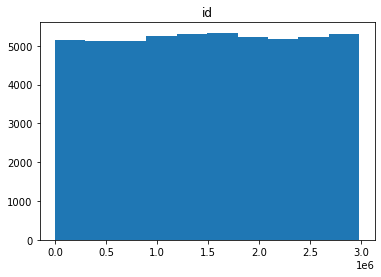

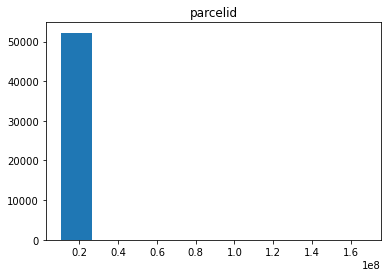

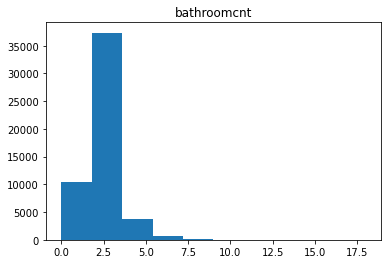

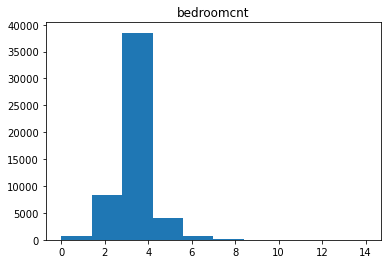

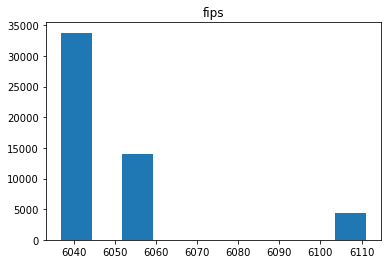

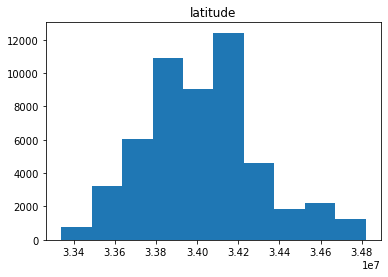

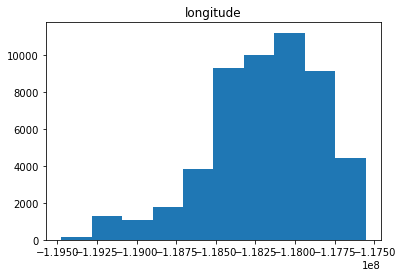

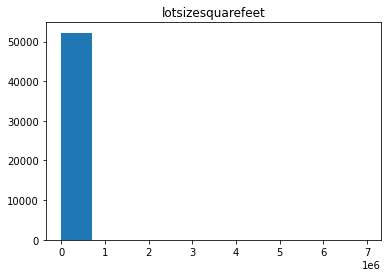

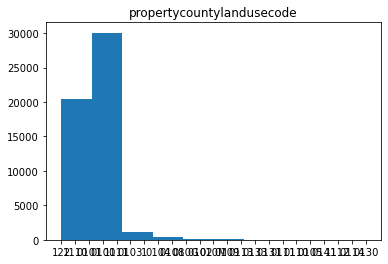

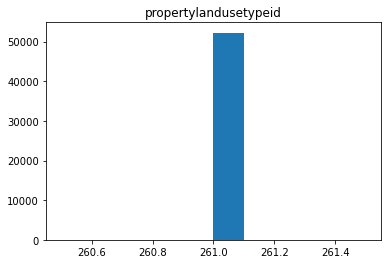

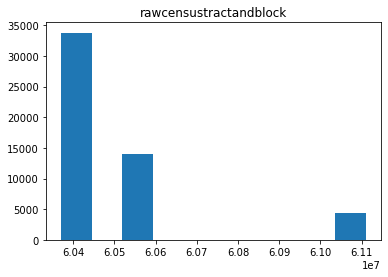

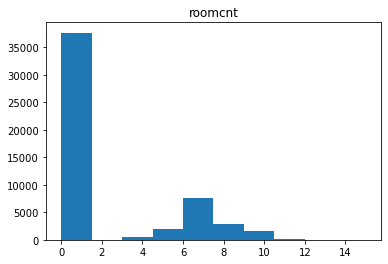

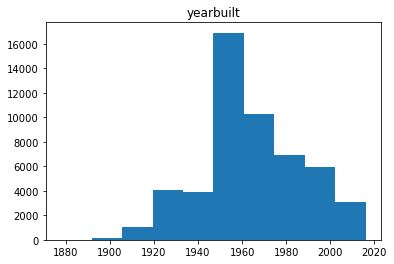

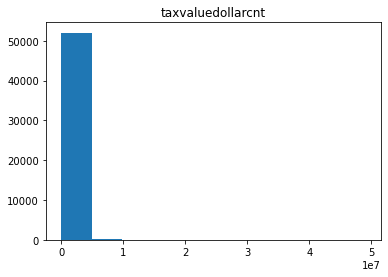

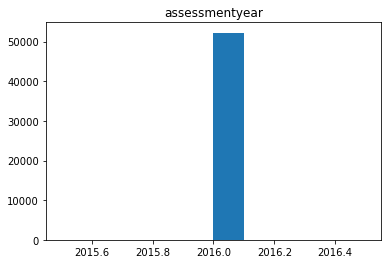

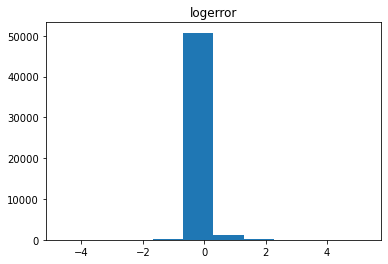

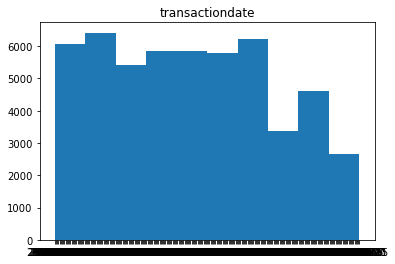

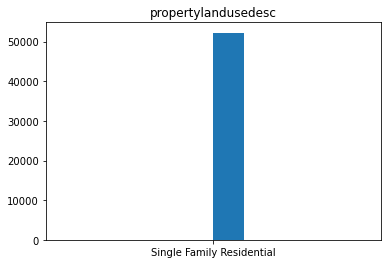

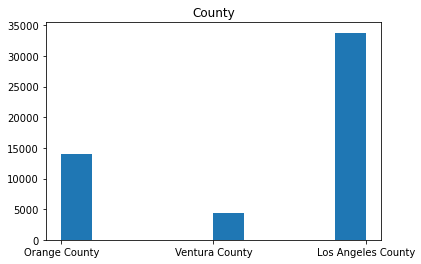

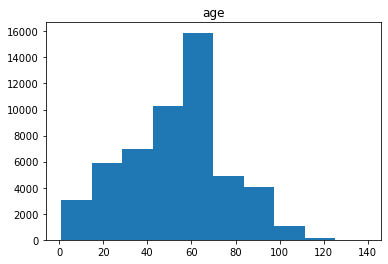

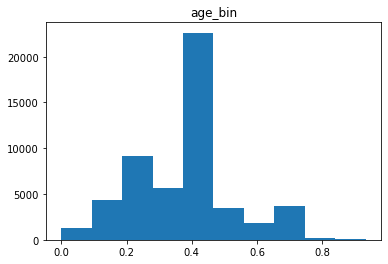

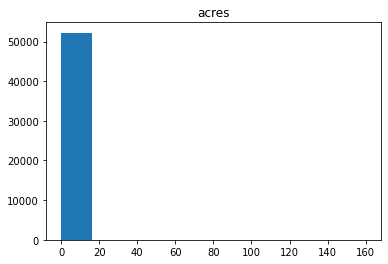

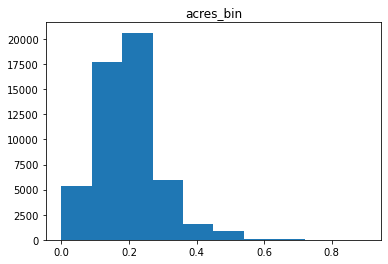

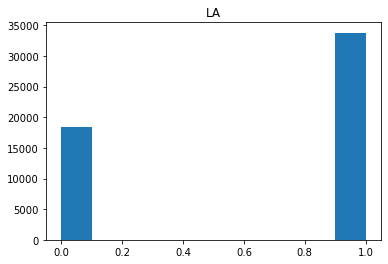

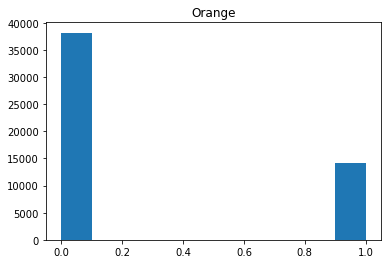

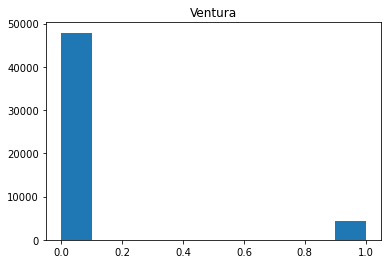

In [28]:
for col in df.columns:
    plt.hist(df[col])
    plt.title(col)
    plt.show()


In [30]:
def remove_outliers():
    '''
    remove outliers in bed, bath, zip, square feet, acres & tax rate
    '''

    return df[((df.bathroomcnt <= 7) & (df.bedroomcnt <= 7) &  
               (df.bathroomcnt > 0) & 
               (df.bedroomcnt > 0) & 
               (df.acres < 20)
              )]


In [31]:
df = remove_outliers()

In [32]:
df.head()

,id,parcelid,bathroomcnt,bedroomcnt,fips,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,propertylandusetypeid,...,transactiondate,propertylandusedesc,County,age,age_bin,acres,acres_bin,LA,Orange,Ventura
0,1727539,14297519,3.5,4.0,6059.0,33634931.0,-117869207.0,4506.0,122,261.0,...,2017-01-01,Single Family Residential,Orange County,19.0,0.133,0.103444,0.1,0,1,0
1,1387261,17052889,1.0,2.0,6111.0,34449266.0,-119281531.0,12647.0,1110,261.0,...,2017-01-01,Single Family Residential,Ventura County,50.0,0.333,0.290335,0.3,0,0,1
2,11677,14186244,2.0,3.0,6059.0,33886168.0,-117823170.0,8432.0,122,261.0,...,2017-01-01,Single Family Residential,Orange County,55.0,0.400,0.193572,0.2,0,1,0
3,2288172,12177905,3.0,4.0,6037.0,34245180.0,-118240722.0,13038.0,0101,261.0,...,2017-01-01,Single Family Residential,Los Angeles County,47.0,0.333,0.299311,0.3,1,0,0
4,781532,12095076,3.0,4.0,6037.0,34145202.0,-118179824.0,63000.0,0101,261.0,...,2017-01-01,Single Family Residential,Los Angeles County,67.0,0.466,1.446281,0.5,1,0,0


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52030 entries, 0 to 52240
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   id                         52030 non-null  int64   
 1   parcelid                   52030 non-null  int64   
 2   bathroomcnt                52030 non-null  float64 
 3   bedroomcnt                 52030 non-null  float64 
 4   fips                       52030 non-null  float64 
 5   latitude                   52030 non-null  float64 
 6   longitude                  52030 non-null  float64 
 7   lotsizesquarefeet          52030 non-null  float64 
 8   propertycountylandusecode  52030 non-null  object  
 9   propertylandusetypeid      52030 non-null  float64 
 10  rawcensustractandblock     52030 non-null  float64 
 11  roomcnt                    52030 non-null  float64 
 12  yearbuilt                  52030 non-null  float64 
 13  taxvaluedollarcnt          5203

##  Data exploration 